# Maximum Likelihood Estimation

In [7]:
import numpy as np
from numpy.random import default_rng, Generator
import matplotlib.pyplot as plt
import torch
from torch.optim import Optimizer, SGD
from torch.distributions.distribution import Distribution
from torch.distributions.cauchy import Cauchy

## Model
Signals are generated from independent Cauchy distribution.
$$
s_{1} \sim Cauchy \left( 0, 1 \right) \\
s_{2} \sim Cauchy \left( 0, 1 \right)
$$

We observe linear mixtures $x_{1}$, $x_{2}$.
$$
x_{1} = w_{1,1}s_{1} + w_{1, 2}s_{2} \\
x_{2} = w_{2,1}s_{1} + w_{1, 2}s_{2}
$$

In [8]:
class GenerativeModel:
    a: np.ndarray
    g: Generator

    def __init__(self, g: Generator):
        self.a = g.standard_normal((2, 2))
        self.g = g

    def signal(self, size: int) -> np.ndarray:
        return self.g.standard_cauchy((size, 2))

    def mix(self, x: np.ndarray) -> np.ndarray:
        return np.dot(self.a, x.T).T


class Inference:
    w: torch.Tensor
    d: Distribution
    g: Generator
    o: Optimizer

    def __init__(self, g: Generator):
        self.w = torch.tensor(g.standard_normal((2, 2)), requires_grad=True)
        self.d = Cauchy(torch.tensor([0, 0]), torch.tensor([1, 1]))
        self.g = g
        self.o = SGD([self.w], lr=0.01, momentum=0.9)

    def update(self, x: np.ndarray) -> None:
        self.o.zero_grad()
        loss = self.loss(x)
        loss.backward()
        self.o.step()

    def loss(self, x: np.ndarray) -> torch.Tensor:
        z = self.w.matmul(torch.from_numpy(x.T))
        return -self.d.log_prob(z.T).mean(0).sum() - torch.log(
            torch.abs(torch.det(self.w))
        )


In [9]:
def attempt(g: Generator) -> None:
    gm = GenerativeModel(g)
    ifr = Inference(g)

    s = gm.signal(1000)
    x = gm.mix(s)

    for _ in range(1000):
        ifr.update(x)

    fig, axs = plt.subplots(1, 2)

    s_samples = s[:50, :]
    x_samples = x[:50, :]
    y_samples = np.dot(ifr.w.detach().numpy(), x_samples.T).T

    for i in range(s_samples.shape[1]):
        axs[i].scatter(s_samples[:, i], y_samples[:, 0], marker=".", alpha=0.3, color="red")
        axs[i].scatter(
            s_samples[:, i], y_samples[:, 1], marker=".", alpha=0.3, color="blue"
        )
        axs[i].scatter(
            s_samples[:, i], x_samples[:, 0], marker=".", alpha=0.3, color="green"
        )
        axs[i].scatter(
            s_samples[:, i], x_samples[:, 1], marker=".", alpha=0.3, color="purple"
        )

        axs[i].set_xlim([-6, 6])
        axs[i].set_ylim([-6, 6])
        axs[i].set_aspect("equal")

    plt.show()

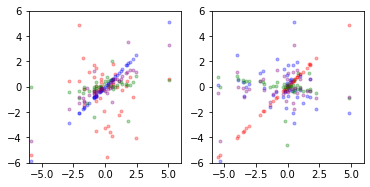

In [10]:
attempt(default_rng(0))

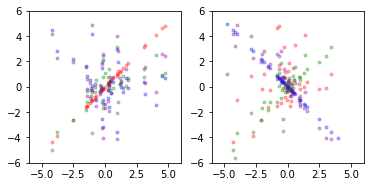

In [11]:
attempt(default_rng(1))

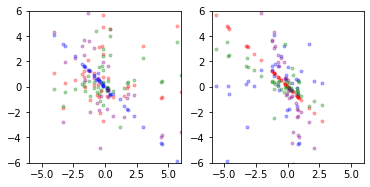

In [12]:
attempt(default_rng(2))